# Proxy App to Predict State of a Dynamical System
#### Pending Concerns
- Validation step is slow. 
- Training loss increases after starting from a lower number for an epoch (for backend floatx set as float16).

#### Handled
- Loss in one epoch is much less than Sai's version. Need to make sure that the loss computation is correct: we need to add loss from the encoder model as well.
- Training is not completing because the model is throwing an error that there should be a call function. Added a call function (earlier the program was stucking at the end) and it runs but need to make sure that it is correct. Also, need to understand how program transits between call and train_step: The call function was missing because we didn't have implementation for test_step and predict_step. We don't need to implement a separate call function, all we need to implement are train_step, test_step, and predict_step. 
- After training, the model is not printing the summary: The main function NeuralNetwork doesn't have trainable model, it is the encoder which is trainable. The encoder was earlier mentioned as a layer but it is a model. Now, training the encoder is working fine.
- Return Psi_X, PSI_X, Psi_Y, PSI_Y, K_loss
- Useful links: https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit and https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

## Import Modules

In [1]:
# Standard Libraries
import os
import time
import numpy as np
import tensorflow as tf

from timeit import default_timer as timer

tf.keras.backend.clear_session()
# tf.keras.backend.set_floatx('float64')
print("[INFO] Tensorflow version: ", tf.__version__)
# print("[INFO] Eager mode: ", tf.executing_eagerly()) # For easy reset of notebook state.

[INFO] Tensorflow version:  2.4.1


In [2]:
# Custom Library
import sys
sys.path.append('../../')

from proxy_apps.data_handler import grid_network
from proxy_apps.apps.timeseries_prediction import deepDMDwithTF
from proxy_apps.plot_lib.simple_plots import eigen_plot, validation_plot, heatmap_matplotlib

In [3]:
N_EPOCHS = 1
keepN = 1000
performance_dict = dict()

## Data Loading and Preprocessing
The input data for the model should be in the form of array. The output array (Y) will have same number of features as the input array (X) but Y would be a time shifted version of the X. In the case of DeepDMD, the shift was equal to 1. In the original application, the data is not sequential and rather restructured using rolling window.

In [4]:
scenario_dir = '../../../../data/TrainingDataIEEE68bus'
print('[INFO]: Loading the datasets from the directory:', scenario_dir)
dir_list = os.listdir(scenario_dir)

# Indicate the scenario range
Dataset = dict()
print('[INFO]: Loading data for %d scenarios ...' % len(dir_list))

[INFO]: Loading the datasets from the directory: ../../../../data/TrainingDataIEEE68bus
[INFO]: Loading data for 30 scenarios ...


### Custom Functions

In [5]:
# tf.config.run_functions_eagerly(True)

In [6]:
def get_data(t: tf.string):
    # fetch directory name
    s_dir = t.numpy().decode('utf-8')
    if s_dir.find('scenario') == -1:
        return None
    
    # get and concatenate data
    dataset = grid_network.TransientDataset('%s/%s/' % (scenario_dir, s_dir))
    raw_data = np.concatenate((dataset.F, dataset.Vm), axis=1)
    
    # return data
    return raw_data

def convert_to_tensor(i):
    d = tf.py_function(func=get_data, inp=[i], Tout=tf.float64)
    d.set_shape(tf.TensorShape([1400, 136]))
    return d

def get_shape(df):
    for a in df.take(1): 
        nrows = a.cardinality().numpy()
        for b in a.take(1): ncols = b.shape[0]
    return (nrows, ncols)

In [7]:
class DatasetGeneratorV2(tf.data.Dataset):
    def _generator(X, Y, scale_factor, norm):
        if X.shape[0] == Y.shape[0]: 
            # number of rows in the data
            d_shape = X.shape[0]
            
            # creating window data
            for i in range(d_shape):
                if norm:
                    x_norm = np.concatenate((scale_factor*(X[i,:68] - 60), 10*(X[i,68:] - 1))) 
                    y_norm = np.concatenate((scale_factor*(Y[i,:68] - 60), 10*(Y[i,68:] - 1))) 
                    yield x_norm, y_norm
                else:
                    yield X[i], Y[i]
            
    def __new__(self, X, Y, scale_factor, norm=True):
        return tf.data.Dataset.from_generator(
            self._generator,
            output_types = (tf.float32, tf.float32),
            output_shapes = ((136,), (136,)),
            args=(X, Y, scale_factor, norm,)
        )

In [8]:
l_start = time.time()
scenario_data = []
count = 0
for s_dir in dir_list:
    if s_dir.find('scenario') == -1:
        continue
    dataset = grid_network.TransientDataset('%s/%s/' % (scenario_dir, s_dir))
    original_shape = np.concatenate((dataset.F, dataset.Vm), axis=1).shape
    scenario_data.append(np.concatenate((dataset.F[:1000,:], dataset.Vm[:1000,:]), axis=1))
    count += 1
    if count % 50 == 0:
        print('[INFO]: Loaded %d/%d scenarios ...' % (count, len(dir_list)))
l_stop = time.time()
print('[INFO]: Time taken for loading datasets:', l_stop - l_start, 'seconds')
print('[INFO]: Total number of scenarios loaded:', len(scenario_data))
print('[INFO]: Shape of each scenario original: ', original_shape)
print('[INFO]: Shape of each scenario loaded: ', scenario_data[0].shape)
print('[INFO]: Done ...')

[INFO]: Time taken for loading datasets: 2.0589778423309326 seconds
[INFO]: Total number of scenarios loaded: 30
[INFO]: Shape of each scenario original:  (1400, 136)
[INFO]: Shape of each scenario loaded:  (1000, 136)
[INFO]: Done ...


In [9]:
# step-2: create data
i_start = time.time()
X_data = [] # Original data
Y_data = [] # 1 time-shifted data
U_data = [] # 2 time-shifted data
V_data = [] # 3 time-shifted data
whole_data = [] # Complete data 
Yp = [] # For analytical calculations
Yf = [] # For analytical calculations
count  = 0
ds  = 1
M = 2 # signifies number of time-shifts
N = 3 # signifies number of time-shifts

for dataset in scenario_data:    
    dataset_size = dataset.shape[0]
    whole_data.append(dataset)      
    Yp.append(dataset[:-1,:])
    Yf.append(dataset[1:,:])
    count += 1
    if count % 50 == 0:
        print('Done processing %d/%d datasets ...' % (count, len(scenario_data)))
    window_size = 800 # length of moving window
    shift_size  = 10 # separation between two moving windows
    i = 0
    while (i*shift_size+window_size+M+N) <= dataset_size:
        X_indices = range(i*shift_size, i*shift_size + window_size,ds)        
        Y_indices = range(i*shift_size+1, i*shift_size + window_size+1,ds)               
        U_indices = range(i*shift_size+M, i*shift_size + window_size+M,ds)               
        V_indices = range(i*shift_size+N, i*shift_size + window_size+N,ds)   
        if count < 0:
            print(X_indices)
            print(Y_indices)
            print(U_indices)
            print(V_indices)        

        i = i + 1
        X_data.append(dataset[X_indices])
        Y_data.append(dataset[Y_indices])
        U_data.append(dataset[U_indices])
        V_data.append(dataset[V_indices])

i_stop = time.time()
print('[INFO]: Time taken for creating X datasets:', i_stop - i_start, 'seconds')
print('[INFO]: Original dataset size:', dataset_size)
print('[INFO]: Chosen dataset size:', window_size)
print('[INFO]: Length of X_data: ', len(X_data))
print('[INFO]: Length of each window after down sampling: ', X_data[0].shape)

[INFO]: Time taken for creating X datasets: 0.8784058094024658 seconds
[INFO]: Original dataset size: 1000
[INFO]: Chosen dataset size: 800
[INFO]: Length of X_data:  600
[INFO]: Length of each window after down sampling:  (800, 136)


In [10]:
# step-3: normalization
n_start = time.time()

X_array = np.asarray(X_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
Y_array = np.asarray(Y_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
U_array = np.asarray(U_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
V_array = np.asarray(V_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
whole_data_array = np.asarray(whole_data).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
Yp_array = np.asarray(Yp).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
Yf_array = np.asarray(Yf).transpose(2,0,1).reshape(dataset.shape[1],-1).transpose()
print("[INFO]: whole_data_array shape:", whole_data_array.shape)
print('[INFO]: Yp_array shape: ', Yp_array.shape)
print('[INFO]: Yf_array shape: ', Yf_array.shape)
print('[INFO]: X_array shape: ', X_array.shape)
print('[INFO]: Y_array shape: ', Y_array.shape)
print('[INFO]: U_array shape: ', U_array.shape)
print('[INFO]: V_array shape: ', V_array.shape)

[INFO]: whole_data_array shape: (30000, 136)
[INFO]: Yp_array shape:  (29970, 136)
[INFO]: Yf_array shape:  (29970, 136)
[INFO]: X_array shape:  (480000, 136)
[INFO]: Y_array shape:  (480000, 136)
[INFO]: U_array shape:  (480000, 136)
[INFO]: V_array shape:  (480000, 136)


## Data Modeling

In [11]:
# Hyperparameters
hyper_param_dict = dict()
hyper_param_dict['original_dim']       = 136   # input data dimension
hyper_param_dict['hl_1_dim']           = 128   # Hidden layer dimension
hyper_param_dict['hl_2_dim']           = 128   # Hidden layer dimension
hyper_param_dict['hl_3_dim']           = 64    # Hidden layer dimension
hyper_param_dict['hl_4_dim']           = 64    # Hidden layer dimension
# hyper_param_dict['hl_5_dim']           = 64  # Hidden layer dimension
hyper_param_dict['latent_dim']         = 64    # Latent space dimension 
hyper_param_dict['reg_factor']         = 0.01  # regularization weight for Koopman
hyper_param_dict['dropout_prob']       = 0.005 # dropout rate [regularization between hidden layers]
hyper_param_dict['weight_regularizer'] = 0.001 # [L1] regularization weight for dense layer weights 
hyper_param_dict['bias_regularizer']   = 0     # [L1] regularization bias for dense layer biases
hyper_param_dict['num_epochs']         = 2    # Number of epochs 
hyper_param_dict['learning_rate']      = 5e-4  # learning rate for optimizer 
hyper_param_dict['validation_split']   = 0.25
hyper_param_dict['batch_size']         = 32

# Initialize Hyperparameters - we can keep it as a dict instead of creating a separate class
hp = deepDMDwithTF.HyperParameters(hyper_param_dict)

In [12]:
norm = True
scale_factor = 2*np.pi 

data_generator = DatasetGeneratorV2(X_array, Y_array, scale_factor=scale_factor, norm=norm)
data_generator = data_generator.batch(hp.bs).cache().prefetch(tf.data.AUTOTUNE)

In [13]:
for sample in data_generator.take(1):
    print(sample)

(<tf.Tensor: shape=(32, 136), dtype=float32, numpy=
array([[ 0.08234169,  0.08398943,  0.08258069, ..., -0.02341259,
        -0.00577598, -0.02499106],
       [ 0.08447362,  0.08528276,  0.08643728, ..., -0.02243011,
        -0.0057455 , -0.02591473],
       [ 0.08655768,  0.08680252,  0.09037708, ..., -0.02138649,
        -0.00570788, -0.02676396],
       ...,
       [ 0.11287867,  0.12505756,  0.12592727, ...,  0.00869706,
        -0.00162953, -0.01244104],
       [ 0.11135866,  0.12386908,  0.12343413, ...,  0.00924739,
        -0.00141313, -0.01077029],
       [ 0.10945581,  0.12239392,  0.12072188, ...,  0.00972899,
        -0.00120123, -0.00908608]], dtype=float32)>, <tf.Tensor: shape=(32, 136), dtype=float32, numpy=
array([[ 0.08447362,  0.08528276,  0.08643728, ..., -0.02243011,
        -0.0057455 , -0.02591473],
       [ 0.08655768,  0.08680252,  0.09037708, ..., -0.02138649,
        -0.00570788, -0.02676396],
       [ 0.08857284,  0.08853229,  0.09436214, ..., -0.02028757,
  

In [14]:
n_batches = X_array.shape[0] // hp.bs
n_batches_training = int(0.75 * n_batches)

training_dataset = data_generator.take(n_batches_training)
val_dataset = data_generator.skip(n_batches_training)

performance_dict["n_epochs"] = hp.ep
performance_dict["batch_size"] = hp.bs
performance_dict["n_training_batches"] = n_batches_training
performance_dict["n_val_batches"] = n_batches - n_batches_training

In [15]:
for sample in training_dataset.take(1):
    print(sample)

(<tf.Tensor: shape=(32, 136), dtype=float32, numpy=
array([[ 0.08234169,  0.08398943,  0.08258069, ..., -0.02341259,
        -0.00577598, -0.02499106],
       [ 0.08447362,  0.08528276,  0.08643728, ..., -0.02243011,
        -0.0057455 , -0.02591473],
       [ 0.08655768,  0.08680252,  0.09037708, ..., -0.02138649,
        -0.00570788, -0.02676396],
       ...,
       [ 0.11287867,  0.12505756,  0.12592727, ...,  0.00869706,
        -0.00162953, -0.01244104],
       [ 0.11135866,  0.12386908,  0.12343413, ...,  0.00924739,
        -0.00141313, -0.01077029],
       [ 0.10945581,  0.12239392,  0.12072188, ...,  0.00972899,
        -0.00120123, -0.00908608]], dtype=float32)>, <tf.Tensor: shape=(32, 136), dtype=float32, numpy=
array([[ 0.08447362,  0.08528276,  0.08643728, ..., -0.02243011,
        -0.0057455 , -0.02591473],
       [ 0.08655768,  0.08680252,  0.09037708, ..., -0.02138649,
        -0.00570788, -0.02676396],
       [ 0.08857284,  0.08853229,  0.09436214, ..., -0.02028757,
  

In [16]:
# Timing callback to measure the timings
class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

timing_cb = TimingCallback()

# Stopping criteria if the training loss doesn't go down by 1e-3
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta = 1e-3, verbose = 1, mode='min', patience = 3, 
    baseline=None, restore_best_weights=True)

m_start = time.time()
K_model = deepDMDwithTF.NeuralNetworkModel(hp)
K_model.compile(optimizer=tf.optimizers.Adagrad(hp.lr))

# In the first iteration, model doesn't know about the number of batches but it knows second epoch onwards. One way to start showing since 
# first iteration is to use steps_per_epoch but that will require you to repeat the training_dataset to make use of complete data in every 
# epoch iteration. validation_steps is important to reduce time in computing validation error.  
history = K_model.fit(training_dataset, \
                      validation_data=val_dataset, \
                      validation_steps=10, \
                      epochs=hp.ep, callbacks=[early_stop_cb, timing_cb], shuffle=True, 
                      workers=4, use_multiprocessing=True
                     )
m_stop = time.time()

# print info
print('[INFO]: Time taken for model training (time module):', m_stop - m_start, 'seconds')
print('[INFO]: Time taken for model training (Keras):', sum(timing_cb.logs), 'seconds')

performance_dict['training_time_module'] = (m_stop - m_start)
performance_dict['training_time_epoch_wise'] = timing_cb.logs
performance_dict['training_loss'] = history.history['loss']
# performance_dict['validation_loss'] = history.history['val_loss']

Epoch 1/2
11250/11250 [==============================] - 104s 9ms/step - loss: 3.5452 - val_loss: 2.5816
Epoch 2/2
11250/11250 [==============================] - 101s 9ms/step - loss: 2.9052 - val_loss: 2.4626
[INFO]: Time taken for model training (time module): 210.95640182495117 seconds
[INFO]: Time taken for model training (Keras): 205.17704103328288 seconds


In [21]:
# test_data = tf.data.Dataset.zip((flat_Yp_data, flat_Yf_data)).batch(29970, drop_remainder=True)
test_generator = DatasetGeneratorV2(Yp_array, Yf_array, scale_factor=scale_factor, norm=norm).batch(29970, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [22]:
for sample in test_generator.take(1):
    print(sample)

(<tf.Tensor: shape=(29970, 136), dtype=float32, numpy=
array([[ 8.2341693e-02,  8.3989434e-02,  8.2580686e-02, ...,
        -2.3412595e-02, -5.7759844e-03, -2.4991060e-02],
       [ 8.4473617e-02,  8.5282758e-02,  8.6437285e-02, ...,
        -2.2430105e-02, -5.7454985e-03, -2.5914732e-02],
       [ 8.6557679e-02,  8.6802520e-02,  9.0377085e-02, ...,
        -2.1386487e-02, -5.7078791e-03, -2.6763964e-02],
       ...,
       [-9.0096146e-05,  8.0493354e-04,  8.9247327e-04, ...,
         4.3701413e-04,  2.2864041e-04,  1.2709794e-03],
       [-7.1816867e-05,  7.4785907e-04,  8.2982838e-04, ...,
         4.3609351e-04,  2.2779674e-04,  1.2645946e-03],
       [-5.2896521e-05,  6.8592728e-04,  7.6210441e-04, ...,
         4.3519892e-04,  2.2702331e-04,  1.2596501e-03]], dtype=float32)>, <tf.Tensor: shape=(29970, 136), dtype=float32, numpy=
array([[ 8.4473617e-02,  8.5282758e-02,  8.6437285e-02, ...,
        -2.2430105e-02, -5.7454985e-03, -2.5914732e-02],
       [ 8.6557679e-02,  8.6802520e

Koopman loss: 28.5250
Psi_X shape: (29970, 64)
Psi_Y shape: (29970, 64)
PSI_X shape: (29970, 200)
PSI_X shape: (29970, 200)


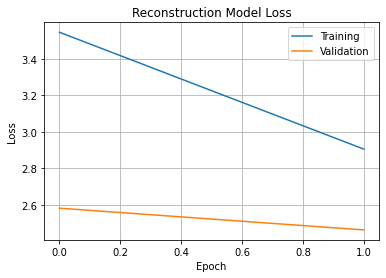

In [23]:
inf_time_start = time.time()

Psi_X, PSI_X, Psi_Y, PSI_Y, Kloss = K_model.predict(test_generator)

inf_time_stop = time.time()
performance_dict["inference_size"] = 29970
performance_dict["inference_time"] = inf_time_stop - inf_time_start
performance_dict["test_Kloss_model"] = Kloss

print("Koopman loss: %.4f" %Kloss)

print('Psi_X shape:', Psi_X.shape)
print('Psi_Y shape:', Psi_Y.shape)
print('PSI_X shape:', PSI_X.shape)
print('PSI_X shape:', PSI_Y.shape)

# Plot training & validation loss values
validation_plot(history)

[INFO]: Shape of Koopman operator (200, 200)
[INFO]: Norm of Koopman operator 9.758252
[INFO]: Trace of K_deepDMD: 4.1127
[INFO]: One time-step error with K_deepDMD: 28.52491


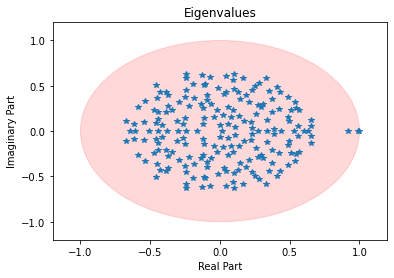

In [24]:
K_deepDMD = K_model.KO.numpy()

print('[INFO]: Shape of Koopman operator', K_deepDMD.shape)
print('[INFO]: Norm of Koopman operator', np.linalg.norm(K_deepDMD))
print('[INFO]: Trace of K_deepDMD:',np.trace(K_deepDMD))
print('[INFO]: One time-step error with K_deepDMD:', np.linalg.norm(PSI_Y - np.matmul(PSI_X, K_deepDMD), ord = 'fro'))

[eigenvaluesK, eigenvectorsK] = np.linalg.eig(K_deepDMD)

performance_dict["test_Kloss_calc"] = np.linalg.norm(PSI_Y - np.matmul(PSI_X, K_deepDMD), ord = 'fro')
performance_dict["eigen_real"] = list(eigenvaluesK.real)
performance_dict["eigen_imag"] = list(eigenvaluesK.imag)

eigen_plot(eigenvaluesK.real, eigenvaluesK.imag)

In [25]:
K_model.encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer (DenseLayer)     multiple                  17536     
_________________________________________________________________
dense_layer_1 (DenseLayer)   multiple                  16512     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_layer_2 (DenseLayer)   multiple                  8256      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_layer_3 (DenseLayer)   multiple                  4160      
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0   

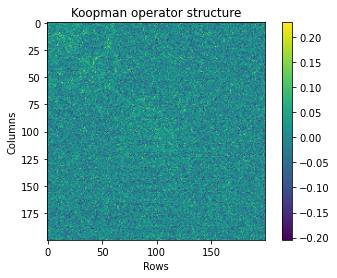

In [26]:
heatmap_matplotlib(K_deepDMD, title='Koopman operator structure')

In [27]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

NameError: name 'json' is not defined

In [27]:
import json
with open("performance.json", 'w') as fp:
    json.dump(performance_dict, fp, cls=NpEncoder)